# Open CVを用いた画像変換の方法
- [こちら](https://qiita.com/icoxfog417/items/53e61496ad980c41a08e)の記事をもとに勉強
- [個人メモ](https://www.evernote.com/l/AEdDer3xm25HyqkCMfnhpXqA9kCYhqAq110)

In [227]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# matplot形式に変換
def to_matplotlib_format(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 画像の表示
def show_image(img_array):
    pil_img = Image.fromarray(img_array)
    pil_img.show()

# グレースケールへの変換

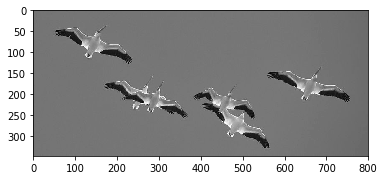

In [228]:
def to_grayscale(path):
    img = cv2.imread(path)
    grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return grayed

grayed_image = to_grayscale('./img/birds.jpg')

# 第2引数に cmap='gray'を指定しないと色がおかしくなる
# https://stackoverflow.com/questions/43228246/show-grayscale-opencv-image-with-matplotlib
plt.imshow(grayed_image, cmap='gray')

# 閾値処理

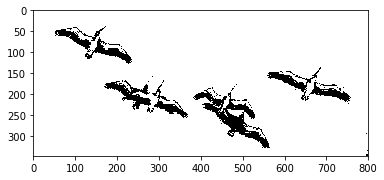

In [241]:
def binary_threshold(path, under_thresh, upper_thresh):
    img = cv2.imread(path)
    grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    maxValue = 255
    
    # しきい値より大きい値 (明るい) を　白にして、しきい値より小さい値(暗い)を黒にする
    th, drop_back = cv2.threshold(grayed, under_thresh, maxValue, cv2.THRESH_BINARY)
    
    # しきい値より大きい値 (明るい) を黒にして、しきい値より小さい値(暗い)を白にする
    th, clarify_born = cv2.threshold(grayed, upper_thresh, maxValue, cv2.THRESH_BINARY_INV)
    
    # 数値の低い方、つまり黒い方を残す。
    merged = np.minimum(drop_back, clarify_born)
    return merged

threshold_image = binary_threshold('./img/birds.jpg', 105, 145)
plt.imshow(threshold_image, cmap='gray')

### Step1 : cv2.threshold(grayed, under_thresh, maxValue, cv2.THRESH_BINARY)の処理
- しきい値より大きい値 (明るい色) を白色にしている
- ここでは空の色をしきい値として、空を白抜きにするようにしている

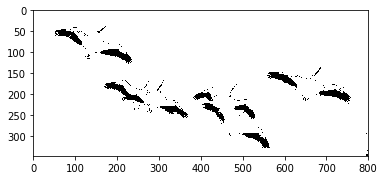

In [230]:
def binary_threshold_step1(path):
    img = cv2.imread(path)
    grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    under_thresh = 105
    maxValue = 255
    
    # しきい値より大きい値 (明るい) を　白にして、しきい値より小さい値(暗い)を黒にする
    th, drop_back = cv2.threshold(grayed, under_thresh, maxValue, cv2.THRESH_BINARY)
    return drop_back

grayed_image = binary_threshold_step1('./img/birds.jpg')
plt.imshow(grayed_image, cmap='gray')

### Step3: cv2.threshold(grayed, upper_thresh, maxValue, cv2.THRESH_BINARY_INV)の処理
- しきい値より大きい値 (明るい色) を黒色にしている
- ここでは鳥の骨の部分を黒色にしている

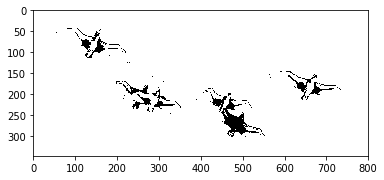

In [231]:
def binary_threshold_step2(path):
    img = cv2.imread(path)
    grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    upper_thresh = 145
    maxValue = 255
       
    # しきい値より大きい値 (明るい) を黒にして、しきい値より小さい値(暗い)を白にする
    th, clarify_born = cv2.threshold(grayed, upper_thresh, maxValue, cv2.THRESH_BINARY_INV)
    
    return clarify_born

grayed_image = binary_threshold_step2('./img/birds.jpg')
plt.imshow(grayed_image, cmap='gray')

# 空の色を抜く
- [HSVとRGBの違いと利点](https://www.peko-step.com/html/hsv.html)
- [色とHSVの値について](https://www.peko-step.com/tool/hsvrgb.html)

- HSVでは、色相について (0~360度)で設定し、彩度、明度は (0% ~ 100%)の範囲で指定する
- OpenCVにおいては、色相について 1/2を掛けた値を設定する (つまり 0 ~ 180となる)
- 彩度、明度については (0~255)の値を設定するため、 255 * 彩度の値(0~1)を設定する。
    - 例えば、 彩度 90の場合は、255*0.9 = 230を設定する

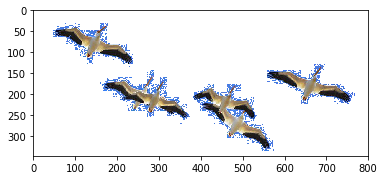

In [232]:
def mask_blue(path):
    img = cv2.imread(path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 空の色をHSV指定する
    # Hue(色相), Saturation(彩度), Value(明度)の順に指定
    #　彩度は値が大きいほど、色鮮やかになり、明度は値が大きいほど、明るい色になる (白色になる)
    blue_min = np.array([100, 170, 200], np.uint8)
    blue_max = np.array([120, 180, 255], np.uint8)
    blue_region = cv2.inRange(hsv, blue_min, blue_max)
    
    # 全面白色の変換対象画像と同じサイズの画像
    white = np.full(img.shape, 255, dtype=img.dtype)
    # blue_regionのところだけbitに1が立ち、それ以外は0となるため、空以外は、黒色 (0,0,0) となる
    background = cv2.bitwise_and(white, white, mask=blue_region) 
    
    # bule_regionのbitの論理反転を行ったため、今度は空は0で、空以外は1となる
    inv_mask = cv2.bitwise_not(blue_region) 
    # 空は0で論理積をとるため、空は黒、それ以外はもとの画像が残る
    extracted = cv2.bitwise_and(img, img, mask=inv_mask)

    # bitの足し算を行う。 
    # 空については、255 + 0 = 255(白色), 
    # 空以外は、0 + 元の画像のRGB値 = 元の画像のRGB値 となる 
    masked = cv2.add(extracted, background)
    
    return masked

image = mask_blue('./img/birds.jpg')
image = to_matplotlib_format(image)
plt.imshow(image)

### Step1: 空を白色にして、空以外を黒色にする処理

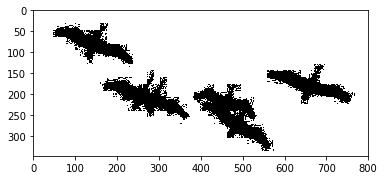

In [233]:
def mask_blue_step1(path):
    img = cv2.imread(path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 空の色をHSV指定する
    blue_min = np.array([100, 170, 200], np.uint8)
    blue_max = np.array([120, 180, 255], np.uint8)
    blue_region = cv2.inRange(hsv, blue_min, blue_max)
    
    # 全面白色の変換対象画像と同じサイズの画像
    white = np.full(img.shape, 255, dtype=img.dtype)
    # blue_regionのところだけbitに1が立ち、それ以外は0となるため、空以外は、黒色 (0,0,0) となる
    background = cv2.bitwise_and(white, white, mask=blue_region) 
        
    return background

image = mask_blue_step1('./img/birds.jpg')
image = to_matplotlib_format(image)
plt.imshow(image)

### Step2: 空を黒にして、それ以外の部分を残す処理

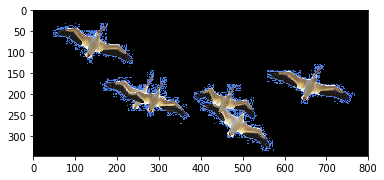

In [234]:
def mask_blue_step2(path):
    img = cv2.imread(path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 空の色をHSV指定する
    blue_min = np.array([100, 170, 200], np.uint8)
    blue_max = np.array([120, 180, 255], np.uint8)
    blue_region = cv2.inRange(hsv, blue_min, blue_max)
        
    # bule_regionのbitの論理反転を行ったため、今度は空は0で、空以外は1となる
    inv_mask = cv2.bitwise_not(blue_region) 
    # 空は0で論理積をとるため、空は黒、それ以外はもとの画像が残る
    extracted = cv2.bitwise_and(img, img, mask=inv_mask)
    
    return extracted

image = mask_blue_step2('./img/birds.jpg')
image = to_matplotlib_format(image)
plt.imshow(image)

# 画像内の特定の位置におけるRGB値とHSV値を取得する

In [235]:
import cv2
image = cv2.imread("./img/birds.jpg")
# x軸10~20, y軸 10~20の座標軸の範囲における、各ピクセルのBGR値の出力
part_image = image[10:20, 10:20]
part_image

array([[[223, 121,  69],
        [223, 121,  69],
        [224, 122,  70],
        [223, 121,  69],
        [223, 121,  69],
        [223, 121,  69],
        [222, 119,  70],
        [222, 119,  70],
        [222, 119,  70],
        [223, 120,  71]],

       [[223, 121,  69],
        [223, 121,  69],
        [224, 122,  70],
        [223, 121,  69],
        [223, 121,  69],
        [223, 121,  69],
        [222, 119,  70],
        [222, 119,  70],
        [222, 119,  70],
        [223, 120,  71]],

       [[223, 121,  69],
        [223, 121,  69],
        [224, 122,  70],
        [223, 121,  69],
        [223, 121,  69],
        [223, 121,  69],
        [222, 119,  70],
        [222, 119,  70],
        [222, 119,  70],
        [223, 120,  71]],

       [[223, 121,  69],
        [223, 121,  69],
        [224, 122,  70],
        [223, 121,  69],
        [223, 121,  69],
        [223, 121,  69],
        [222, 119,  70],
        [222, 119,  70],
        [222, 119,  70],
        [223, 120, 

上記の例では、概ね、 B: 220 ~ 225,  G: 119 ~ 122,  R: 69~71の値をとっていることがわかる

In [236]:
# BGRを HSV形式に変換
cv2.cvtColor(part_image, cv2.COLOR_BGR2HSV)

array([[[110, 176, 223],
        [110, 176, 223],
        [110, 175, 224],
        [110, 176, 223],
        [110, 176, 223],
        [110, 176, 223],
        [110, 175, 222],
        [110, 175, 222],
        [110, 175, 222],
        [110, 174, 223]],

       [[110, 176, 223],
        [110, 176, 223],
        [110, 175, 224],
        [110, 176, 223],
        [110, 176, 223],
        [110, 176, 223],
        [110, 175, 222],
        [110, 175, 222],
        [110, 175, 222],
        [110, 174, 223]],

       [[110, 176, 223],
        [110, 176, 223],
        [110, 175, 224],
        [110, 176, 223],
        [110, 176, 223],
        [110, 176, 223],
        [110, 175, 222],
        [110, 175, 222],
        [110, 175, 222],
        [110, 174, 223]],

       [[110, 176, 223],
        [110, 176, 223],
        [110, 175, 224],
        [110, 176, 223],
        [110, 176, 223],
        [110, 176, 223],
        [110, 175, 222],
        [110, 175, 222],
        [110, 175, 222],
        [110, 174, 

上記の例では、概ね、H: 110, S: 174~176, V: 222 ~ 224 の値をとっていることがわかる。

# 平滑化(スムージング)について

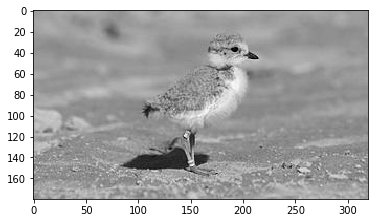

In [237]:
# しきい値処理
def binary_threshold_for_smoothing(grayed, dark_line_thresh, light_line_thresh):
    # 引数で指定された値よりも小さい値(暗い色)を黒くし、大きい値(明るい色)を白くする。
    th, d_lined = cv2.threshold(grayed, dark_line_thresh, 255, cv2.THRESH_BINARY)
    # 引数で指定された値よりも小さい値(暗い色)を白くし、大きい値(明るい色)を黒くする。
    th, l_lined = cv2.threshold(grayed, light_line_thresh, 255, cv2.THRESH_BINARY_INV)    
    merged = np.minimum(d_lined, l_lined)
    return merged

grayed = to_grayscale('img/bird_for_smoothing.jpg')
plt.imshow(grayed, cmap='gray')

### スムージング処理なしでの閾値処理

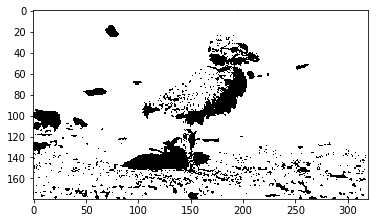

In [238]:
threshold_image = binary_threshold_for_smoothing(grayed, 100, 150)
plt.imshow(threshold_image, cmap='gray')

### GaussianBlurの処理
- 画像をぼやけさせる

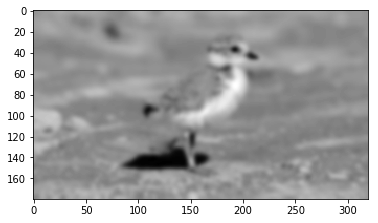

In [239]:
def blur(img):
    filtered = cv2.GaussianBlur(img, (11, 11), 0)
    return filtered

blured_image = blur(grayed)
plt.imshow(blured_image, cmap='gray')

### GaussianBlurを行った後での閾値処理

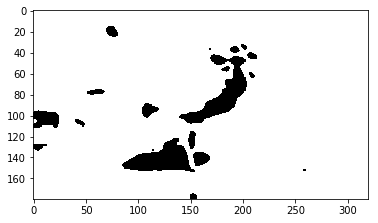

In [240]:
threshold_image = binary_threshold_for_smoothing(blured_image, 100, 150)
plt.imshow(threshold_image, cmap='gray')

# 物体検出
- OpenCVで画像の輪郭抽出を行う場合には、findContoursという関数を使う
- [cv2.findContours](https://qiita.com/anyamaru/items/fd3d894966a98098376c)について


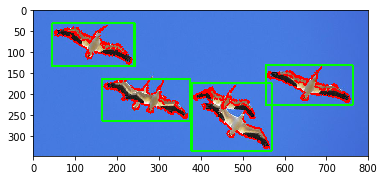

In [246]:
def detect_contour(path, min_size):
    # 輪郭線の描画用画像
    contoured = cv2.imread(path)
    # 対象画像を切り取るための画像
    forcrop = cv2.imread(path)
    
    # make binary image
    birds = binary_threshold(path, 105, 145)
    birds = cv2.bitwise_not(birds)
    
    # 第一引数に入力画像、第二引数に抽出モード、第三引数に近似手法をとる
    # RETR_EXTERNALは、輪郭のうち、最も外側の輪郭のみを抽出するモード
    # 近似手法については、良く分かっていないが、殆どの場合、CHAIN_APPROX_SIMPLEという手法を取るらしい
    im2, contours, hierarchy = cv2.findContours(birds, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 対象画像の切り抜き用
    crops = []
    
    # draw contour (輪郭線を描く)
    for c in contours:
        
        # 引数で指定された最小サイズよりも、輪郭線が小さい場合はスキップする
        if cv2.contourArea(c) < min_size:
            continue
        
        # 対象部分を四角で囲った部分の座標と大きさを取得
        x, y, w, h = cv2.boundingRect(c)
        x, y, w, h = padding_position(x, y, w, h, 5)

        # 対象画像の切り取り
        cropped = forcrop[y:(y + h), x:(x + w)]
        # 大きさを変える (拡大する)
        # cropped = resize_image(cropped, (210, 210))
        crops.append(cropped)
        
        # 境界線と四角の描画
        cv2.drawContours(contoured, c, -1, (0, 0, 255), 3) 
        cv2.rectangle(contoured, (x, y), (x + w, y + h), (0, 255, 0), 3)
    return contoured, crops
        
    
def padding_position(x, y, w, h, p):
    return x - p, y - p, w + p * 2, h + p * 2

contoured, crops = detect_contour('./img/birds.jpg', 30)
contoured = to_matplotlib_format(contoured)
plt.imshow(contoured)